In [1]:
from constants import DATA_PATH
import pandas as pd

df = pd.read_csv(DATA_PATH / 'sentinel-1-processed.csv')

df

,VH-pol,VV-pol,SM1 (%),Crop Name,label
0,-19.3557,-13.54610,4.6,Fallow,Low
1,-17.1605,-10.46910,7.2,Pearl Millet,Low
2,-17.8729,-9.98927,6.4,Fallow,Low
3,-17.7906,-11.93460,9.6,Lemon,Low
4,-17.3646,-10.73270,3.9,Fallow,Low
...,...,...,...,...,...
1811,-16.7871,-11.17010,50.0,Wheat,Very High
1812,-17.2167,-12.15740,50.0,Wheat,Very High
1813,-17.7785,-10.37820,50.0,Tobacco,Very High
1814,-16.6607,-10.62890,50.0,Tobacco,Very High


In [2]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df['Crop Labels'] = le.fit_transform(df['Crop Name'])

In [3]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder(categories=[['Low', 'Medium', 'High', 'Very High']])

df['label'] = oe.fit_transform(df[['label']])

In [4]:
X_cols = ['VH-pol', 'VV-pol', 'Crop Labels']
y_col = 'label'

X = df[X_cols].values
y = df[[y_col]].values.flatten()

X.shape, y.shape

((1816, 3), (1816,))

In [5]:
X, y

(array([[-19.3557 , -13.5461 ,   2.     ],
        [-17.1605 , -10.4691 ,  13.     ],
        [-17.8729 ,  -9.98927,   2.     ],
        ...,
        [-17.7785 , -10.3782 ,  16.     ],
        [-16.6607 , -10.6289 ,  16.     ],
        [-17.4057 , -10.6208 ,  15.     ]], shape=(1816, 3)),
 array([0., 0., 0., ..., 3., 3., 3.], shape=(1816,)))

# Random Forest

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print(classification_report(y_test, y_pred, target_names=oe.categories_[0]))

              precision    recall  f1-score   support

         Low       0.50      0.58      0.54        85
      Medium       0.28      0.25      0.26        85
        High       0.34      0.34      0.34        90
   Very High       0.56      0.53      0.54       104

    accuracy                           0.43       364
   macro avg       0.42      0.42      0.42       364
weighted avg       0.42      0.43      0.43       364



# XGBoost

In [8]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred, target_names=oe.categories_[0]))

              precision    recall  f1-score   support

         Low       0.56      0.59      0.57        85
      Medium       0.36      0.34      0.35        85
        High       0.36      0.39      0.38        90
   Very High       0.55      0.52      0.53       104

    accuracy                           0.46       364
   macro avg       0.46      0.46      0.46       364
weighted avg       0.46      0.46      0.46       364



In [9]:
X_train, y_train

(array([[-17.1902 , -10.8471 ,   2.     ],
        [-14.0663 ,  -9.24351,  19.     ],
        [-16.5633 , -10.673  ,  11.     ],
        ...,
        [-12.1954 ,  -6.70816,   2.     ],
        [-18.0218 , -12.691  ,   2.     ],
        [-18.203  ,  -9.75805,   1.     ]], shape=(1452, 3)),
 array([0., 2., 3., ..., 2., 3., 2.], shape=(1452,)))

# ANN

In [10]:
from sklearn.preprocessing import MinMaxScaler

X = df[X_cols]
y = df[[y_col]]


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25
)

# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.astype('int32')
y_test = y_test.astype('int32')
y_val = y_val.astype('int32')

In [11]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1], )),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4,)
])

optim = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
    optimizer=optim,
    loss=loss,
    metrics=['accuracy']
)

history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_data=(X_val_scaled, y_val))

2025-10-24 16:41:19.533392: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


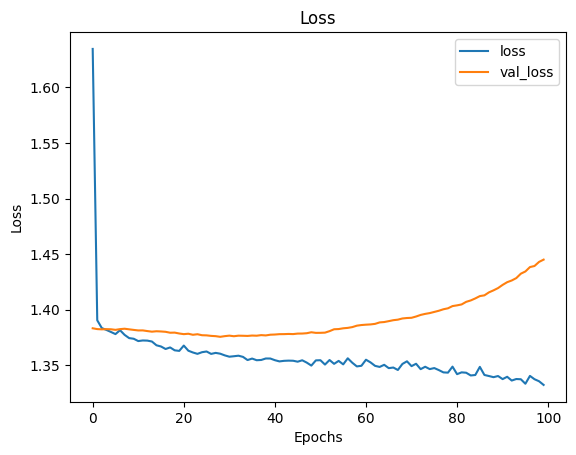

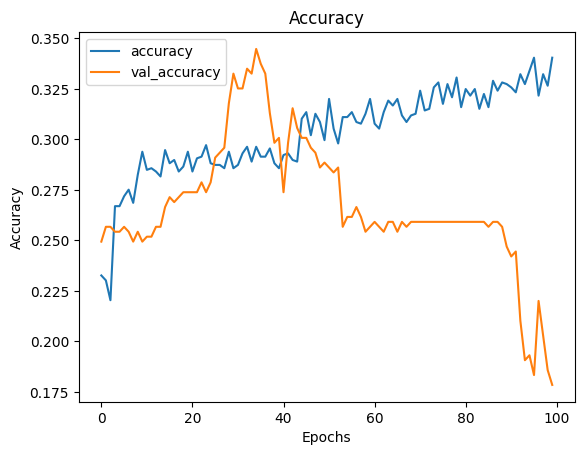

In [12]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

history_df[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [18]:
import numpy as np

logits = model.predict(X_test)
preds = [np.argmax(l) for l in logits]

print(classification_report(y_test, preds))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

           0       0.28      0.82      0.42        39
           1       0.50      0.02      0.04        47
           2       0.47      0.53      0.50        43
           3       0.29      0.09      0.14        53

    accuracy                           0.34       182
   macro avg       0.39      0.37      0.28       182
weighted avg       0.39      0.34      0.26       182

